## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

In [18]:
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.datasets import CIFAR10

%matplotlib inline

In [19]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


def plot_images(images, cls_true, cls_pred=None):
    """
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

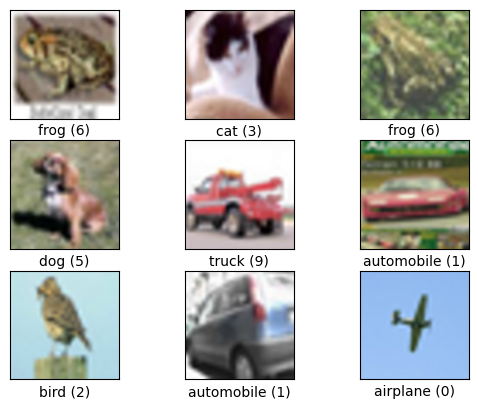

In [20]:
def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed=1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=True,
                           num_workers=1,
                           pin_memory=True):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms for validation (no augmentation)
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    # Define the transform for training (and data augmentation)

    if augment:
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),  # Randomly flip images
            transforms.RandomCrop(32, padding=4),  # Randomly crop with padding
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color variations
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images if requested
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = next(data_iter)
        # Unnormalize the images for display
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        unnorm_images = [unnormalize(img, mean, std) for img in images]
        X = torch.stack(unnorm_images).numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

def unnormalize(img, mean, std):
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return img

trainloader, valloader = get_train_valid_loader()

# Convolutional Neural Network Architecture

Please first review the CNN lecture and problem statement pdf to understand the overall architecture of a CNN and how each dimension evolves after each layer, we'll take as example the first and famous CNN LeNet5 :
<figure align="center">
  <img src="https://doimages.nyc3.cdn.digitaloceanspaces.com/010AI-ML/content/images/2021/10/image-17.png" alt="LeNet5 Architecture" width="600">
  <figcaption>Image credit: <a href="https://en.wikipedia.org">Wikipedia</a></figcaption>
</figure>

# **Theory - Part 1 (20%)**

Please answer the following questions to assess your understanding of what happens during the training and inference of a CNN.

If you find any of these questions challenging or have any doubts, feel free to ask a TA for guidance or hints on the solution.

## 1. First Layer Convolution

If we consider the input of LeNet5 to be CIFAR-10, what would be the shape of the parameters of the first convolutional layer (stride = 1)?

- **A.** `torch.Size([6, 1, 5, 5])`
- **B.** `torch.Size([6, 3, 3, 3])`
- **C.** `torch.Size([6, 1, 5, 5])`
- **D.** `torch.Size([6, 3, 5, 5])`

## Ans1:

CIFAR-10 is a dataset with RGB images of size 32x32. As we can see in the image, the output of the first convolutional layer produces 6 **activation maps** with size 28x28. if we know that the output size is 28x28, the stride is 1 and the original image is 32x32 (N), we can easily compute the size of the filter with the following formula
$$
\text{Output Size} = \frac{N-F}{\text{stride}} + 1
$$
This gives us a size (F) of the filter of 5x5. Furthermore RGB is a 3 channel format.

Thus, the answer is **D**

## 2. Subsampling Window

What is the shape of the subsampling window (stride = 2) for the second layer (between C1 and C2), and does this shape remain invariant regardless of the subsampling method (e.g., Avg pooling or Max pooling)?

- **A.** `2x2, yes it does`
- **B.** `3x3, no it doesn't`
- **C.** `2x2, no it doesn't`
- **D.** `yes, it does`


## Ans2:

The correct answer is **A**.

We start with 6 activation layers of size 28x28 and we get 6 activation layers of size 14x14. Here we can use the following furmula to compute the width of the filter 

$$
\text{Output Size} = \frac{N-F}{\text{stride}} + 1
$$

This gives us a filter size of 2x2. Regarding the shape invariace, the answer is yes. The only things that will change if we change the subsampling method are the values inside the generated "image".

## 3. Backpropagation for Convolutional Filters

Do the filters in the convolutional layers also benefit from backpropagation?

## Ans3:

Yes, absolutely. The backpropagation is the method we use to update the parameters of the filters inside the convolutional layers. 

## 4. Role of the Fully-Connected Layer

Explain in your own words why it is necessary to have a fully-connected layer in the architecture.


## Ans4:

After the convolutional part, we need to have at least one fully-connected layer in the architecture to allow the decision making, so to make the classification in the different classes. Sometimes more of these layers are present inside the net. A FC-layer serves also as feature aggregation layer, so it will weight and combine the contribution of the extracted features to make the best decision.

# **Coding(60%)**

## Build your own Convolutional Neural Network Architecture

## Different ways to improve the accuracy of your network :
- Change the number of convolutions and layers (you can take inspiration from internet as you as you cite the architecture)
- Change the optmizer / its hyperparameters
- Add new types of layers
- Do some data augmentation in the get_train_valid_loader function (flipped, cropped, uncentered images) cf. https://pytorch.org/vision/stable/transforms.html


## <span style="color: red">IMPORTANT</span> 
This is only the last version of the net. Furthermore, the best model was trained with a different training function. All the design process and net architecture, as well as the training process is described in the attached notebook called `CIFAR10_quadri.ipynb`. Please have a look at it to see in detail how this final net was build!

In [21]:
from torchsummary import summary

class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3, n_output=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=n_input_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, n_output)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))

        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)
    
# print the number of parameters in the model
model = ConvNet()
model = model.to('cuda')
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 4, 4]         295,168
      BatchNorm2d-11            [-1, 256, 4, 4]             512
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-13            [-1, 512, 4, 4]           1,024
           Conv2d-14            [-1, 51

In [22]:
net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

epochs = 10
steps = 0
running_loss = 0
print_every = 200
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):

        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        #                                                                              #
        ################################################################################
        images, targets = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = net(images)

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

        loss = criterion(output, targets)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        
        loss.backward()
        optimizer.step()

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

        running_loss += loss.item()

        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            net.eval()
            total_images = 0
            for ii, (images, labels) in enumerate(valloader):

                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                images, targets = images.to(device), labels.to(device)
                output = net(images)
                _, predicted = torch.max(output.data, 1)
                accuracy += (predicted == targets).sum().item()
                total_images += targets.size(0)

                # Important: the accuracy calculation was changed, now it is a percentage 
                # value and not the number of correct images as before



                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################

            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "Test accuracy: {:.4f}%..".format(accuracy/total_images*100),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
            running_loss = 0
            start = time.time()

Epoch: 1/10.. Loss: 1.8493.. Test accuracy: 34.3000%.. 0.0097 s/batch
Epoch: 1/10.. Loss: 1.6456.. Test accuracy: 41.8000%.. 0.0096 s/batch
Epoch: 1/10.. Loss: 1.3874.. Test accuracy: 52.4000%.. 0.0097 s/batch
Epoch: 2/10.. Loss: 1.2473.. Test accuracy: 55.2000%.. 0.0021 s/batch
Epoch: 2/10.. Loss: 1.1238.. Test accuracy: 59.3000%.. 0.0102 s/batch
Epoch: 2/10.. Loss: 1.0421.. Test accuracy: 62.8000%.. 0.0094 s/batch
Epoch: 2/10.. Loss: 0.9991.. Test accuracy: 65.9000%.. 0.0103 s/batch
Epoch: 3/10.. Loss: 0.9305.. Test accuracy: 66.6000%.. 0.0035 s/batch
Epoch: 3/10.. Loss: 0.8466.. Test accuracy: 68.1000%.. 0.0096 s/batch
Epoch: 3/10.. Loss: 0.8335.. Test accuracy: 69.4000%.. 0.0119 s/batch
Epoch: 3/10.. Loss: 0.7987.. Test accuracy: 71.7000%.. 0.0093 s/batch
Epoch: 4/10.. Loss: 0.7470.. Test accuracy: 71.1000%.. 0.0051 s/batch
Epoch: 4/10.. Loss: 0.6872.. Test accuracy: 72.6000%.. 0.0092 s/batch
Epoch: 4/10.. Loss: 0.6766.. Test accuracy: 73.3000%.. 0.0093 s/batch
Epoch: 4/10.. Loss: 

Save best trained model.

In [23]:
## You should be familiar with how to save a pytorch model (Make sure to save the model in your Drive)
# torch.save(net.state_dict(), 'model.pth')

# Load the already trained model
model = ConvNet()
model.load_state_dict(torch.load('cifar10_quadri/best_model.pth'))
model.eval()


ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runni

## Accuracy of the best model

In [24]:
accuracy_best = 0
total_images_best = 0

model.to(device)

for ii, (images, labels) in enumerate(valloader):
    images, targets = images.to(device), labels.to(device)
    output = model(images)
    _, predicted = torch.max(output.data, 1)
    accuracy_best += (predicted == targets).sum().item()
    total_images_best += targets.size(0)

print("Test accuracy: {:.4f}%..".format(accuracy_best/total_images_best*100))

Test accuracy: 94.9000%..


## <span style="color: green">Important</span>
This accuracy makes not really sense because the partition of the dataset used to train this model probably includes the the images used in the evaluation. The correct accuracy should be around 86%

# Some visualisations and Interpretation questions
This code allows us to look at the filters of the first layer of convolution :

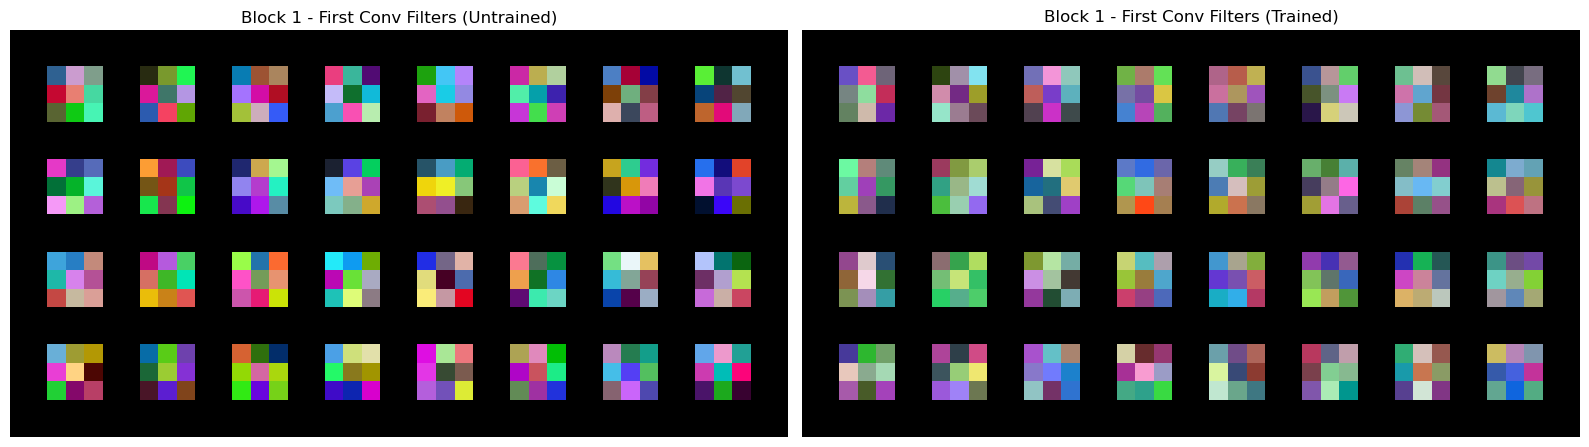

In [25]:
def visualize_filters(layer, title='Filters'):
    filters = layer.weight.data.clone().cpu()
    filters = (filters - filters.min()) / (filters.max() - filters.min())
    grid = vutils.make_grid(filters, nrow=8, padding=2)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

model = ConvNet()
model.eval()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Untrained filters ---
filters_untrained = model.conv1.weight.data.clone().cpu()
filters_untrained = (filters_untrained - filters_untrained.min()) / (filters_untrained.max() - filters_untrained.min())
grid_untrained = vutils.make_grid(filters_untrained, nrow=8, padding=2)
axes[0].imshow(grid_untrained.permute(1, 2, 0))
axes[0].set_title("Block 1 - First Conv Filters (Untrained)")
axes[0].axis("off")

# --- Trained filters ---
filters_trained = net.conv1.weight.data.clone().cpu()
filters_trained = (filters_trained - filters_trained.min()) / (filters_trained.max() - filters_trained.min())
grid_trained = vutils.make_grid(filters_trained, nrow=8, padding=2)
axes[1].imshow(grid_trained.permute(1, 2, 0))
axes[1].set_title("Block 1 - First Conv Filters (Trained)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

#### What do you notice about the filters after the training ? Try to fin an interpretation about it.


### <span style="color: green">Interpretation</span>
In the first image (untrained) we can see a (pseudo) random initialisation. The color changes within the filters are very irregular and there is no visible *pattern*. On the other hand, the trained one shows some structure and order in the color pattern: smoother color transitions, some kind of edges/shapes, ... This means that the model has learned to recognise certain features from the images in the dataset.

In a more general way, we can say that this convolutional layer probably acts as a feature extractor and the recognisable patterns show that this representation of the signal was learned during training. Furthermore, the differences in the patterns suggest that different features have been extracted. These features are then weighted and combined to perform the final classification.

### Activation maps
This code snippet uses a forward hook to capture the output of the first convolutional layer of a CNN when a sample image is passed through it. The resulting activation maps show how each filter in the layer responds to different regions or features in the image.

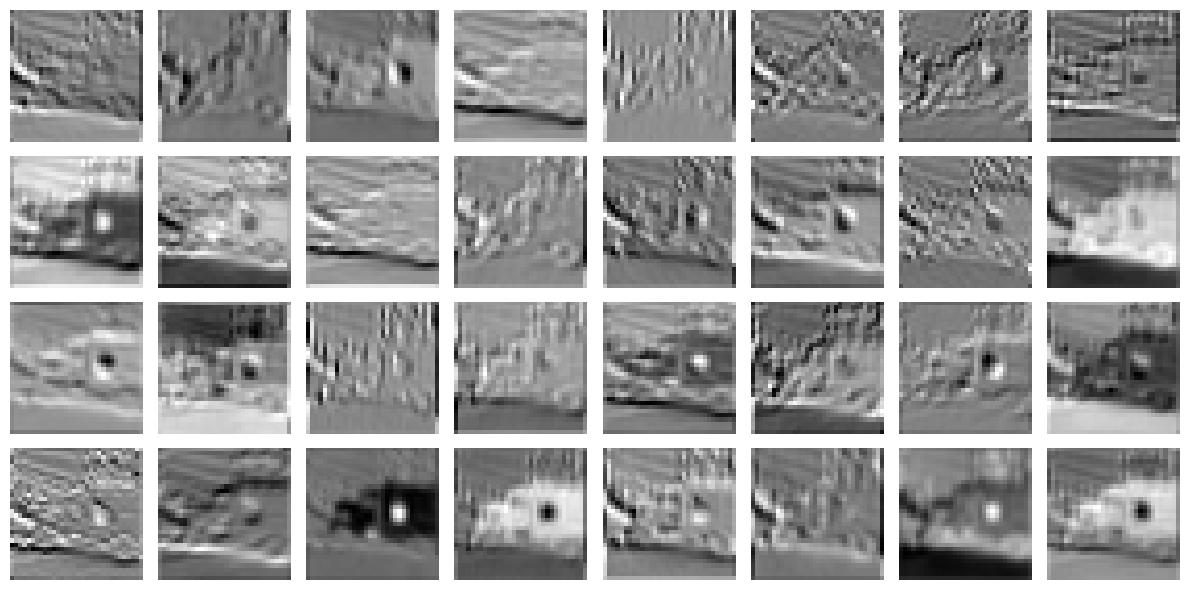

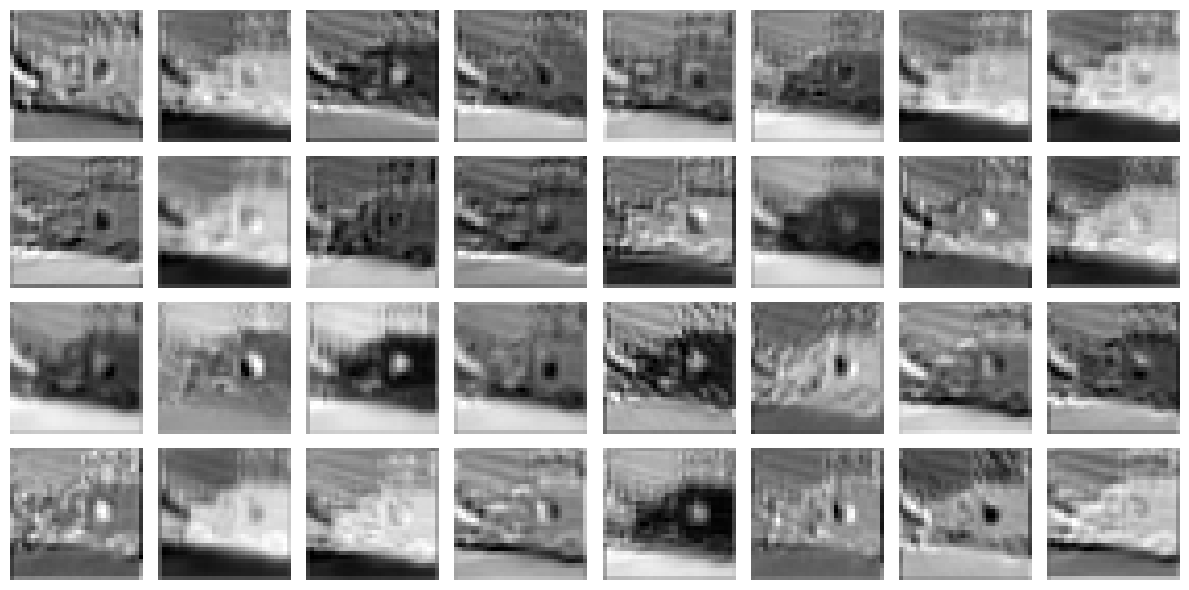

In [26]:
def get_activation(model, layer, x):
    activation = {}
    def hook_fn(module, input, output):
        activation['output'] = output.detach().cpu()
    hook = layer.register_forward_hook(hook_fn)
    model(x)
    hook.remove()
    return activation['output']

data_iter = iter(trainloader)
sample_images, sample_labels = next(data_iter)
sample_img = sample_images[0].unsqueeze(0)

net = ConvNet()
net.load_state_dict(torch.load('cifar10_quadri/best_model.pth'))
net.eval()

net.to('cuda')
sample_img = sample_img.to('cuda')
model.to('cuda')

# Get the feature maps after the first convolution (for example)
activation = get_activation(net, net.conv1, sample_img)
activation_untrained = get_activation(model, model.conv1, sample_img)
# Visualize a few feature maps in RGB:
def plot_feature_maps(feature_maps, n_cols=8):
    n_features = feature_maps.shape[1]
    n_rows = (n_features + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    for i in range(n_features):
        plt.subplot(n_rows, n_cols, i + 1)
        # Extract the i-th feature map from the first (and only) sample in the batch
        act = feature_maps[0, i, :, :]
        # Normalize the activation map to [0, 1]
        act_norm = (act - act.min()) / (act.max() - act.min() + 1e-8)
        # Repeat the single channel 3 times to form an RGB image
        act_rgb = act_norm.unsqueeze(0).repeat(3, 1, 1)
        plt.imshow(act_rgb.permute(1, 2, 0))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_feature_maps(activation, n_cols=8)
plot_feature_maps(activation_untrained, n_cols=8)

# Play with the index of the chosen sample to notice more patterns and answer the questions

# **Theory - Part 2 (20%)**

Please answer the following questions based on your experience/observation during the training and inference of a CNN.

If you find any of these questions challenging or have any doubts, feel free to ask a TA for guidance or hints on the solution.


## 5. Feature Detection
What specific features do you observe in these activation maps? Do some maps clearly highlight edges, contours, or textures? How might these features relate to the overall structure of the sample (e.g., the outline of a horse)?

## Ans5:
The activation maps illustrate how the filters in the convolutional layer affect the input image. Some of the maps emphatize the contours of the object, while others try to differentiate between the foreground and background, for example by playing with the contrast. Furthermore, certain layers seem to highlight details related to the texture/material of the object, such as smoothness or feather-like patterns.

By combining all these features, the network gets the necessary information to extract and identify the object within the image. Furthermore, texture-specific maps provide additional elements that (might) help distinguish between similar classes. For example, both a dog and a deer have four legs, but texture-related filters can help differentiate them based on characteristics like fur length.

## 6. Effect of Training
Consider how the activations might change after training versus an untrained (random) network. What does this tell you about the learning process?

## Ans6:

What we can see is that the network is able to learn the filters that allow the extraction of meaningful features that facilitate the classification process. This highlights the hierarchical nature of deep learning, where the model progressively learns how to detect relevant patterns. Throughout the training process, the feature extraction is improved. Those features will then be used by deeper layer to classify the image.